# Load Data and Word-Embedding Models

In [2]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [3]:
random_vector = {}
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('random')
        if size not in random_vector:
            random_vector[size] = torch.randn(size)
        return random_vector[size]

# LSTM Implementation

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [5]:

import re

def clean_word(word):
    import string
    # Removing all punctuation characters using a translation table
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    # Stripping whitespace and newline characters
    clean_word = clean_word.strip()
    
    # Convert an empty string to a whitespace of equivalent length of the original word
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word

def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cpu', epochs=10):
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                # text = data["text"].split()
                pattern = r'[ ]+'
                text = re.split(pattern, data["text"])
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cpu'):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 27   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [9]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.4470, Accuracy: 0.8908, F1: 0.3089
Validation: Loss: 0.3034, Accuracy: 0.9210, F1: 0.4199
Epoch 2/10
Training: Loss: 0.2735, Accuracy: 0.9256, F1: 0.4738
Validation: Loss: 0.2602, Accuracy: 0.9316, F1: 0.5379
Epoch 3/10
Training: Loss: 0.2322, Accuracy: 0.9354, F1: 0.5703
Validation: Loss: 0.2446, Accuracy: 0.9367, F1: 0.5851
Epoch 4/10
Training: Loss: 0.2053, Accuracy: 0.9410, F1: 0.6245
Validation: Loss: 0.2385, Accuracy: 0.9377, F1: 0.6105
Epoch 5/10
Training: Loss: 0.1838, Accuracy: 0.9458, F1: 0.6645
Validation: Loss: 0.2356, Accuracy: 0.9380, F1: 0.6202
Epoch 6/10
Training: Loss: 0.1662, Accuracy: 0.9505, F1: 0.6989
Validation: Loss: 0.2352, Accuracy: 0.9391, F1: 0.6319
Epoch 7/10
Training: Loss: 0.1508, Accuracy: 0.9542, F1: 0.7244
Validation: Loss: 0.2407, Accuracy: 0.9388, F1: 0.6336
Epoch 8/10
Training: Loss: 0.1367, Accuracy: 0.9578, F1: 0.7483
Validation: Loss: 0.2446, Accuracy: 0.9389, F1: 0.6272
Epoch 9/10
Training: Loss: 0.1245, Accuracy: 0.9

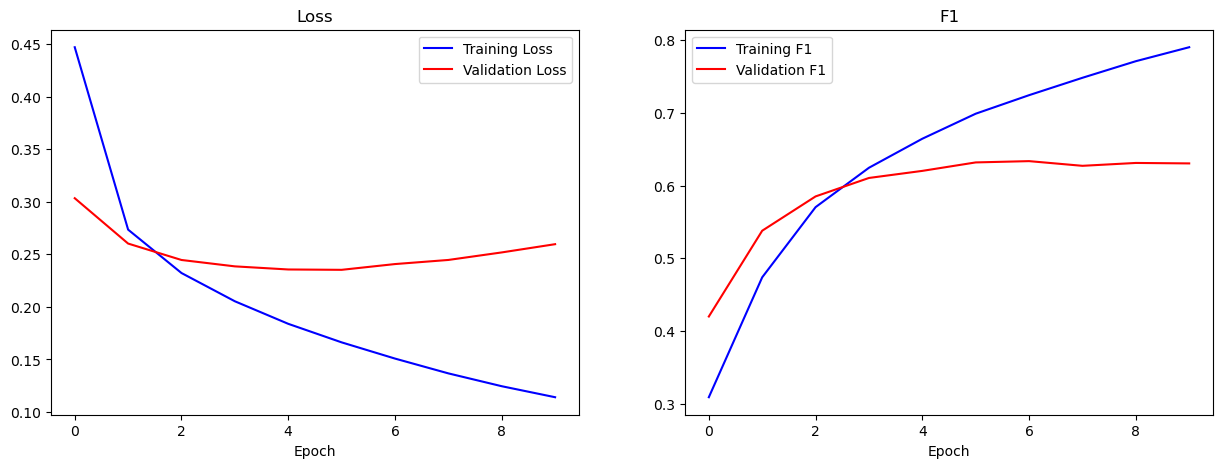

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
torch.save(lstm_word2vec_model, "t1_model2_word2vec.pt")

In [13]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cpu')
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

LSTM with Word2Vec ==> Accuracy: 0.9349, F1: 0.6177


# For GloVe Embeddings

In [14]:
lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)

In [15]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.5615, Accuracy: 0.8643, F1: 0.1383
Validation: Loss: 0.4674, Accuracy: 0.8840, F1: 0.2107
Epoch 2/10
Training: Loss: 0.4445, Accuracy: 0.8868, F1: 0.2398
Validation: Loss: 0.4233, Accuracy: 0.8918, F1: 0.2477
Epoch 3/10
Training: Loss: 0.4083, Accuracy: 0.8931, F1: 0.2765
Validation: Loss: 0.4082, Accuracy: 0.8952, F1: 0.2844
Epoch 4/10
Training: Loss: 0.3850, Accuracy: 0.8986, F1: 0.3248
Validation: Loss: 0.3976, Accuracy: 0.8968, F1: 0.3244
Epoch 5/10
Training: Loss: 0.3680, Accuracy: 0.9026, F1: 0.3710
Validation: Loss: 0.3983, Accuracy: 0.8962, F1: 0.3297
Epoch 6/10
Training: Loss: 0.3521, Accuracy: 0.9063, F1: 0.4021
Validation: Loss: 0.3987, Accuracy: 0.8962, F1: 0.3614
Epoch 7/10
Training: Loss: 0.3406, Accuracy: 0.9092, F1: 0.4243
Validation: Loss: 0.3997, Accuracy: 0.8969, F1: 0.3681
Epoch 8/10
Training: Loss: 0.3313, Accuracy: 0.9110, F1: 0.4398
Validation: Loss: 0.3955, Accuracy: 0.8974, F1: 0.3806
Epoch 9/10
Training: Loss: 0.3216, Accuracy: 0.9

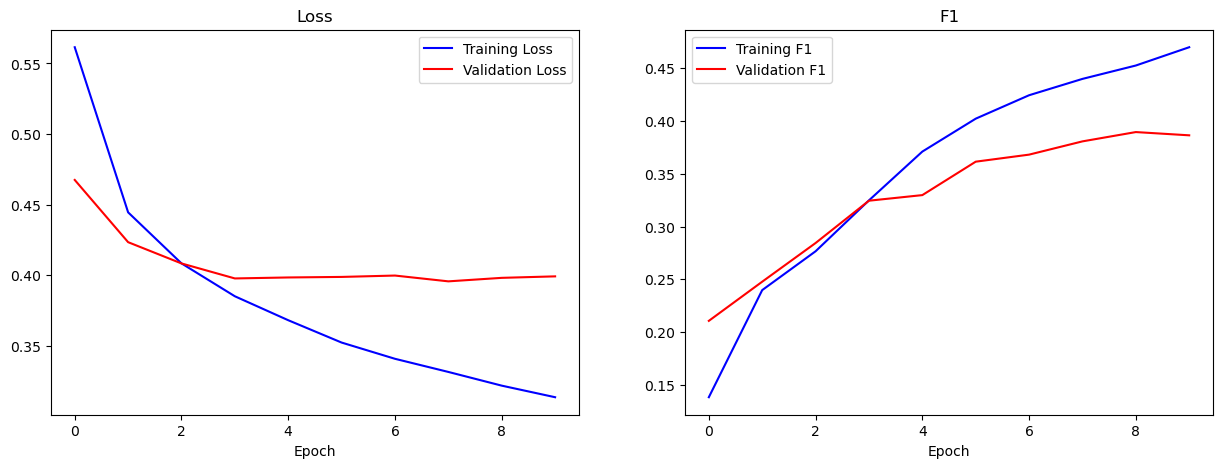

In [16]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [17]:
torch.save(lstm_glove_model, "t1_model2_glove.pt")

In [18]:
test_accuracy, test_f1 = test("t1_model2_glove.pt", glove, test_data, device='cpu')
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

LSTM with GloVe ==> Accuracy: 0.8969, F1: 0.3688


# For FastText Embeddings

In [19]:
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)

In [20]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.4708, Accuracy: 0.8850, F1: 0.2668
Validation: Loss: 0.3082, Accuracy: 0.9183, F1: 0.3875
Epoch 2/10
Training: Loss: 0.2822, Accuracy: 0.9227, F1: 0.4326
Validation: Loss: 0.2618, Accuracy: 0.9289, F1: 0.4537
Epoch 3/10
Training: Loss: 0.2433, Accuracy: 0.9312, F1: 0.4887
Validation: Loss: 0.2451, Accuracy: 0.9327, F1: 0.4932
Epoch 4/10
Training: Loss: 0.2195, Accuracy: 0.9368, F1: 0.5362
Validation: Loss: 0.2355, Accuracy: 0.9346, F1: 0.5319
Epoch 5/10
Training: Loss: 0.2002, Accuracy: 0.9414, F1: 0.5833
Validation: Loss: 0.2291, Accuracy: 0.9360, F1: 0.5688
Epoch 6/10
Training: Loss: 0.1837, Accuracy: 0.9449, F1: 0.6248
Validation: Loss: 0.2263, Accuracy: 0.9370, F1: 0.5929
Epoch 7/10
Training: Loss: 0.1692, Accuracy: 0.9485, F1: 0.6590
Validation: Loss: 0.2243, Accuracy: 0.9379, F1: 0.5980
Epoch 8/10
Training: Loss: 0.1569, Accuracy: 0.9517, F1: 0.6841
Validation: Loss: 0.2246, Accuracy: 0.9383, F1: 0.6049
Epoch 9/10
Training: Loss: 0.1450, Accuracy: 0.9

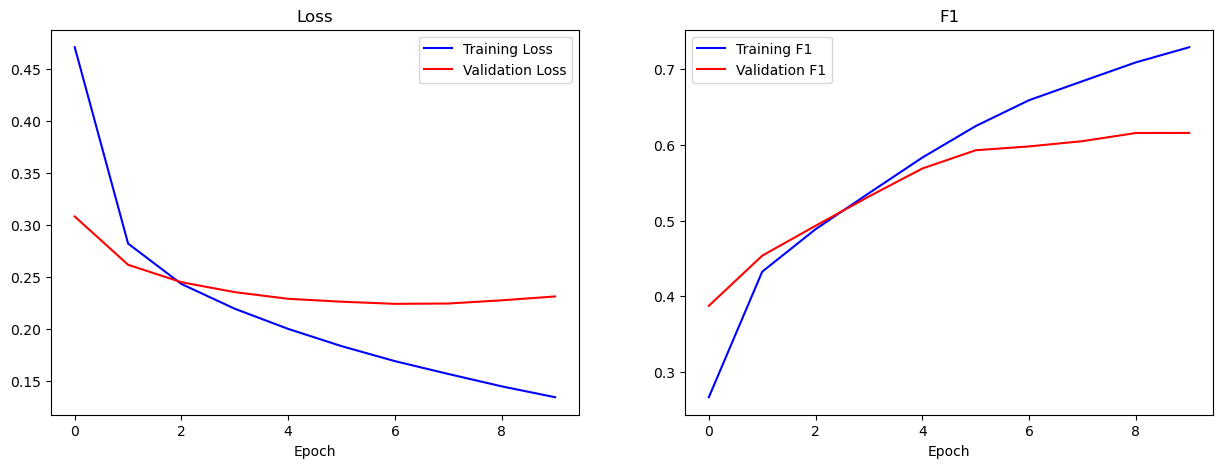

In [21]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [22]:
torch.save(lstm_fasttext_model, "t1_model2_fasttext.pt")

In [23]:
test_accuracy, test_f1 = test("t1_model2_fasttext.pt", fasttext, test_data, device='cpu')
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

LSTM with FastText ==> Accuracy: 0.9366, F1: 0.5833
